In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
from dotenv import load_dotenv
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../../Datasets/3_earthquake_1995-2023.csv")

df.drop(columns=['title'], inplace=True)

Null values in dataset:
Unnamed: 0    0
magnitude     0
cdi           0
mmi           0
alert         0
tsunami       0
sig           0
net           0
nst           0
dmin          0
gap           0
magType       0
depth         0
latitude      0
longitude     0
location      0
continent     0
country       0
day           0
month         0
year          0
dtype: int64


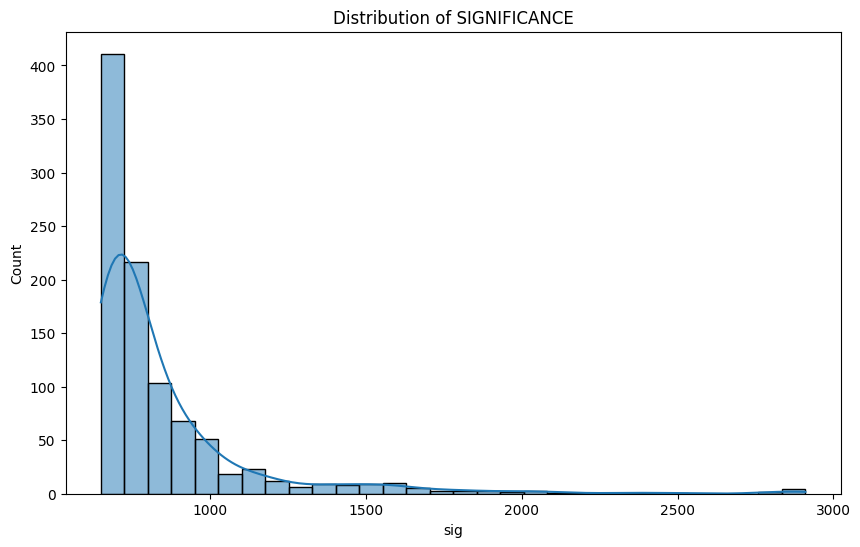

In [3]:
# Check null values and data distribution
print("Null values in dataset:")
print(df.isna().sum())

plt.figure(figsize=(10, 6))
sns.histplot(df['sig'], kde=True, bins=30)
plt.title('Distribution of SIGNIFICANCE')
plt.show()

In [4]:
# Version check
import xgboost as xgb
import sklearn
print(f"XGBoost version: {xgb.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")

XGBoost version: 2.1.3
Scikit-learn version: 1.6.0


In [5]:
# Import required libraries
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from imblearn.over_sampling import SMOTE
import xgboost as xgb

In [6]:
# Prepare features and target
X = df.drop(columns=['sig'])
y = df['sig']

# Identify feature types
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns


In [7]:
# Initialize transformers
transformers = {
    'label_encoders': {},
    'scaler': StandardScaler()
}

# Transform categorical features
X_transformed = X.copy()
for col in categorical_features:
    transformers['label_encoders'][col] = LabelEncoder()
    X_transformed[col] = transformers['label_encoders'][col].fit_transform(X[col])

# Transform numerical features
X_transformed[numerical_features] = transformers['scaler'].fit_transform(X[numerical_features])

In [8]:
# Initialize ShuffleSplit
n_splats = 5

ss = ShuffleSplit(n_splits=n_splats, test_size=(1/n_splats), random_state=42)

# Get first fold for initial split
train_idx, test_idx = next(ss.split(X_transformed))
X_train, X_test = X_transformed.iloc[train_idx], X_transformed.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Feature selection using XGBoost
feature_selector = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)
feature_selector.fit(X_train, y_train)

AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [9]:
# Get feature importance and select top features
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_selector.feature_importances_
}).sort_values(by='Importance', ascending=False)

n_features = 6

selected_features = list(feature_importance.head(n_features)['Feature'])
print("\nTop n_features Selected Features:")
print(feature_importance.head(n_features))

X_train_final = X_train[selected_features]
X_test_final = X_test[selected_features]


Top n_features Selected Features:
      Feature  Importance
4       alert    0.278874
10    magType    0.216507
3         mmi    0.110711
2         cdi    0.102277
5     tsunami    0.054611
1   magnitude    0.044696


In [10]:
# Modified SMOTE implementation with error handling
try:
    # First try with auto k_neighbors
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train_final, y_train)
except ValueError:
    try:
        # If that fails, try with minimum possible k_neighbors
        min_samples = min(y_train.value_counts())
        k_neighbors = min(min_samples - 1, 3)  # Use minimum of (samples-1) or 3
        if k_neighbors < 1:
            print("Not enough samples for SMOTE, using original data...")
            X_train_smote, y_train_smote = X_train_final, y_train
        else:
            print(f"Retrying SMOTE with k_neighbors={k_neighbors}...")
            smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
            X_train_smote, y_train_smote = smote.fit_resample(X_train_final, y_train)
    except Exception as e:
        print(f"SMOTE failed: {str(e)}")
        print("Using original data without SMOTE...")
        X_train_smote, y_train_smote = X_train_final, y_train

Not enough samples for SMOTE, using original data...


In [11]:
# Define parameter combinations for manual cross-validation
param_combinations = [
    {'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.03, 'subsample': 0.9, 'colsample_bytree': 0.6, 'min_child_weight': 2}
]

In [12]:
# Manual cross-validation for parameter tuning
best_score = float('-inf')
best_params = None

print("\nPerforming manual cross-validation for parameter tuning...")
for params in param_combinations:
    model = xgb.XGBRegressor(**params, random_state=42)
    scores = []
    
    for train_idx, val_idx in ss.split(X_train_smote):
        X_train_cv, X_val_cv = X_train_smote.iloc[train_idx], X_train_smote.iloc[val_idx]
        y_train_cv, y_val_cv = y_train_smote.iloc[train_idx], y_train_smote.iloc[val_idx]
        
        model.fit(X_train_cv, y_train_cv)
        pred = model.predict(X_val_cv)
        score = r2_score(y_val_cv, pred)
        scores.append(score)
    
    avg_score = np.mean(scores)
    print(f"Parameters: {params}")
    print(f"Average R² score: {avg_score:.4f}")
    
    if avg_score > best_score:
        best_score = avg_score
        best_params = params

print("\nBest Parameters:")
print(best_params)


Performing manual cross-validation for parameter tuning...
Parameters: {'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.03, 'subsample': 0.9, 'colsample_bytree': 0.6, 'min_child_weight': 2}
Average R² score: 0.7534

Best Parameters:
{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.03, 'subsample': 0.9, 'colsample_bytree': 0.6, 'min_child_weight': 2}


In [13]:
# Train final model with best parameters
xgb_model_tuned = xgb.XGBRegressor(**best_params, random_state=42)
xgb_model_tuned.fit(X_train_smote, y_train_smote)

# Make predictions
y_pred_tuned = xgb_model_tuned.predict(X_test_final)

# Print performance metrics
print("\nTuned Model Performance Metrics:")
print(f"R² Score: {r2_score(y_test, y_pred_tuned):.4f}")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred_tuned):.4f}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_pred_tuned)):.4f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred_tuned):.4f}")


Tuned Model Performance Metrics:
R² Score: 0.8098
Mean Squared Error: 25171.5898
Root Mean Squared Error: 158.6556
Mean Absolute Error: 76.0713


In [14]:
# Cross-validation with ShuffleSplit
cv_scores_tuned = []
for train_idx, val_idx in ss.split(X_train_smote):
    X_train_cv, X_val_cv = X_train_smote.iloc[train_idx], X_train_smote.iloc[val_idx]
    y_train_cv, y_val_cv = y_train_smote.iloc[train_idx], y_train_smote.iloc[val_idx]
    
    model = xgb.XGBRegressor(**best_params, random_state=42)
    model.fit(X_train_cv, y_train_cv)
    pred = model.predict(X_val_cv)
    score = r2_score(y_val_cv, pred)
    cv_scores_tuned.append(score)

print(f"\nCross-validation R² scores (tuned model): {cv_scores_tuned}")
print(f"Average CV R² score: {np.mean(cv_scores_tuned):.4f} (+/- {np.std(cv_scores_tuned) * 2:.4f})")



Cross-validation R² scores (tuned model): [0.7337296009063721, 0.6737396717071533, 0.7694661617279053, 0.7719924449920654, 0.8179594278335571]
Average CV R² score: 0.7534 (+/- 0.0959)


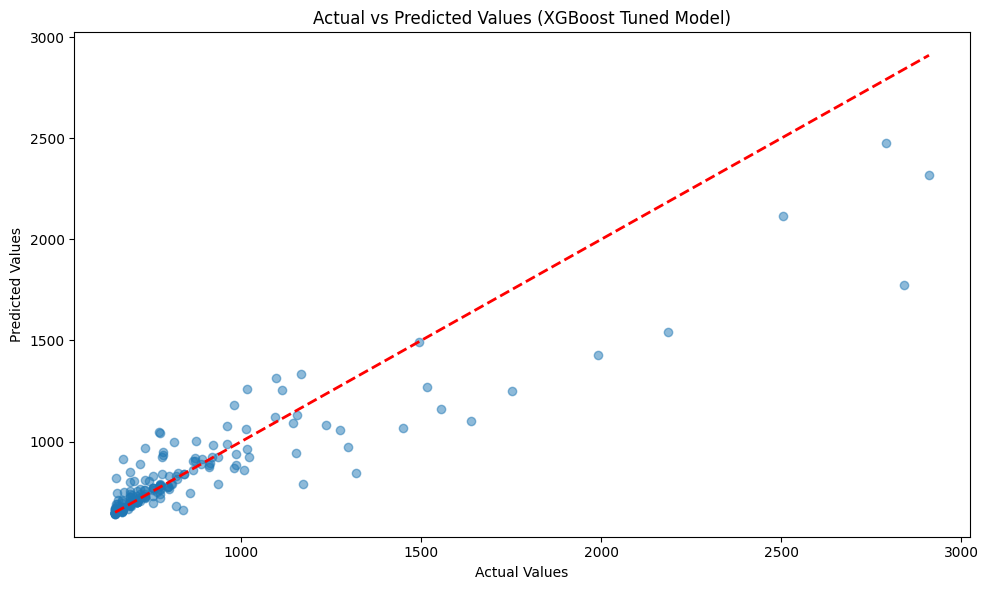

In [15]:
# Visualizations
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_tuned, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values (XGBoost Tuned Model)')
plt.tight_layout()
plt.show()

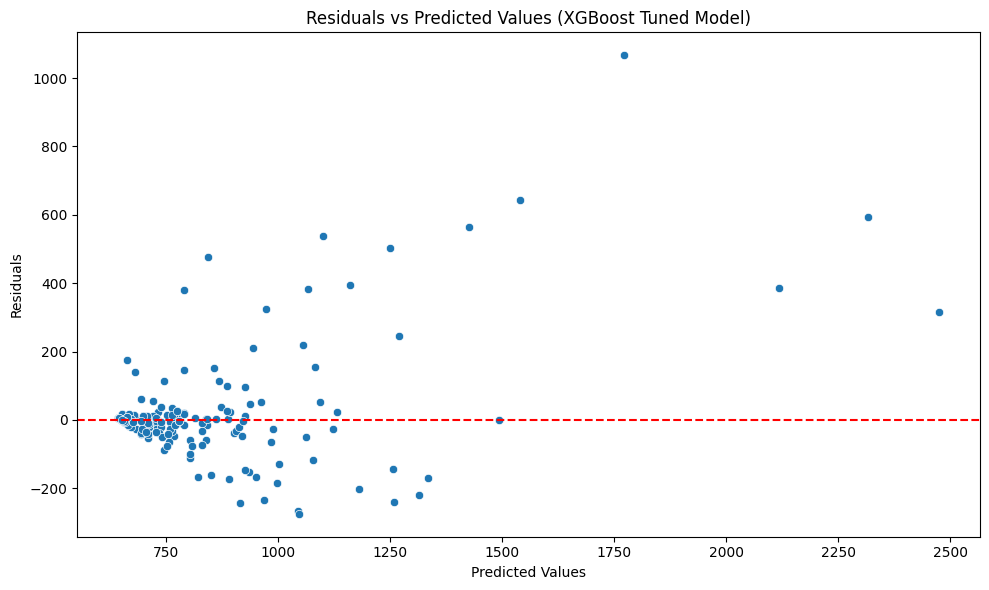

In [16]:
# Residuals Plot
residuals_tuned = y_test - y_pred_tuned
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_tuned, y=residuals_tuned)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values (XGBoost Tuned Model)')
plt.tight_layout()
plt.show()

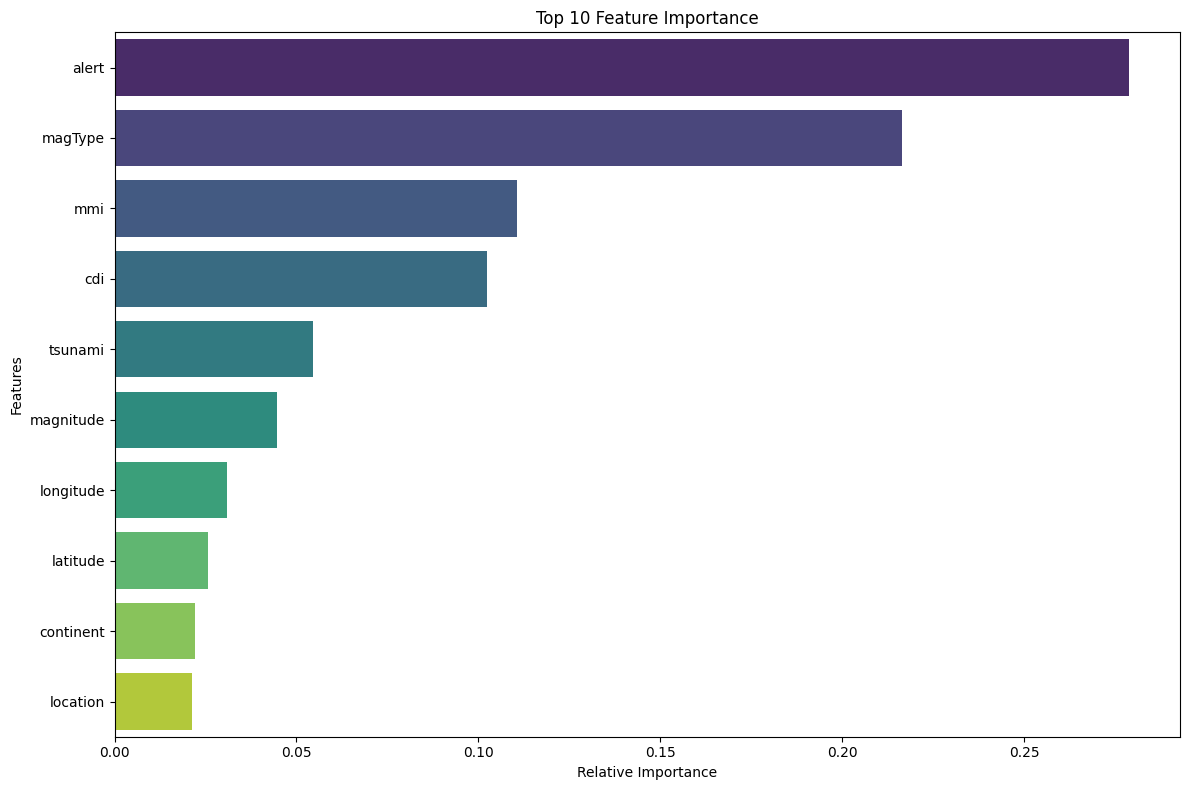

In [17]:
# Feature Importance Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', 
            data=feature_importance.head(10),
            palette='viridis')
plt.title('Top 10 Feature Importance')
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [18]:
from pathlib import Path
import pickle

# Create the models directory path using Path
models_dir = Path("../../Notebooks/Predictions_Training/Models")

# Files to save
files_to_save = {
    'sig_transformers.pkl': transformers,
    'sig_selected_features.pkl': selected_features,
    'sig_feature_info.pkl': {'categorical_features': list(categorical_features),
                             'numerical_features': list(numerical_features)},
    'sig_model.pkl': xgb_model_tuned
}

# Save all necessary files
for filename, content in files_to_save.items():
    file_path = models_dir / filename  # Use / to combine Path object and filename
    with open(file_path, 'wb') as f:
        pickle.dump(content, f)

print(f"\nAll model artifacts saved in {models_dir}")



All model artifacts saved in ..\..\Notebooks\Predictions_Training\Models
